In [1]:
import sys, os, time
from dotenv import load_dotenv
# adding the lates version of the osnap_client to the path
from pathlib import Path
file_path = Path(".").absolute()
sys.path.append(str(file_path.parent))
import json
import re
# display the image
from PIL import Image
from io import BytesIO
import IPython.display
import discord
from osnap_client.adapters import DiscordAdapter
from osnap_client.agents import SwarmAgentBase
from osnap_client.protocol import AgentCommand, AgentCommandType
from osnap_client.utils.ai_engines import DalleEngine, LanchainGoogleEngine, GPTConversEngine

load_dotenv()

True

In [2]:
dalle_engine = DalleEngine()

In [3]:
prompt = "cute cat"
image = dalle_engine.imagine(prompt)

In [7]:
img = Image.open(BytesIO(image))

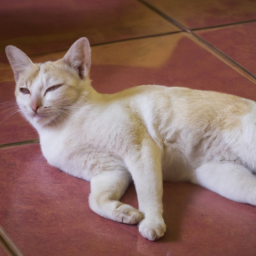

In [9]:
img

In [4]:
class Test:
    def __init__(self, arg1):
        self.arg1 = arg1
        self.arg2 = "arg2"

    def print(self):
        print(json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4))

In [5]:
x = Test("arg1")
x.print()

{
    "arg1": "arg1",
    "arg2": "arg2"
}


In [18]:
class GooglingAgent:
    def __init__(self, name, description):
        self.search_engine = LanchainGoogleEngine("gpt-3.5-turbo", 0.5, 1000)
        self.thinking_engine = GPTConversEngine("gpt-3.5-turbo", 0.5, 1000)

    def research(self, message: AgentCommand):
        try:
            payload = message.payload
            if message.payload_type != "str":
                raise ValueError(f"Expected payload_type to be 'str' but got {message.payload_type}")
            
            if payload == "":
                raise ValueError("Payload cannot be empty")
            
            if not isinstance(payload, str):
                raise ValueError(f"Expected payload to be of type str but got {type(payload)}")

            research_results = self._research(payload)

            response = AgentCommand(
                sender="aaa",
                receiver="agent",
                command_type=AgentCommandType.SUBMIT,
                task_name="imagine",
                payload_type = 'str',
                payload=research_results 
            )
            return response
        except Exception as e:
            print(f"Error in imagine command: {e}")
            response = AgentCommand(
                sender=self.name,
                receiver="agent",
                command_type=AgentCommandType.ERROR,
                task_name="imagine",
                payload_type = 'str',
                payload=f"505: Internal Server Error: {e}",
            )
            return self.swarm_adapter.send_dm(response, message.sender)
    
    def _research(self, topic: str) -> str:
        """Does google search on a given topic and returns the results
        """
        print(f"Researching '{topic}'")
        queries = self._gen_querries(topic)
        results = []
        for query in queries:
            results.append(self._google_search(query))
        response = self._summarize(topic, results)
        return response

    def _google_search(self, query: str)-> str:
        """Does the search itself but provides very short answers!
        """
        query = query.strip().replace("'", "").replace('"', "")
        response = self.search_engine.call_model(query)
        print(f"For query: '{query}', got response: '{response}'")
        return response
    
    def _summarize(self, topic: str, results: list) -> str:
        """Summarizes the results into a single paragraph
        """
        results_summarisation_prompt = (
            "----Results Summarisation Prompt----\n"
            "You will be presented with a global topic and a list of research results related to this topic. Your task is to distill this information into a single, concise paragraph. "
            "The summarisation should capture the essence of the results and their relevance to the global topic. "
            "Focus on highlighting key findings, unique insights, and essential takeaways that are relevant only to the global topic. "
            "The summarisation should be comprehensive yet succinct, enabling anyone to grasp the major points quickly. \n\n"
            "For example, if the global topic is 'Climate Change Impact on Agriculture' and the results include various studies, statistics, and expert opinions, weave them into a coherent, compact summary.\n"
            "--------\n"
        )

        results = "\n".join(results)

        conversation = [
            {"role": "system", "content": results_summarisation_prompt},
            {"role": "user", "content": f"Topic: {topic}.\n\nResults:\n{results}"},
        ]

        response = self.thinking_engine.call_model(conversation)

        print(f"Summarized results: '{response}'")
        return response
    
    def _gen_querries(self, topic: str) -> list:
        """Breaks down the topic into a list of google search querries
        """
        search_query_breakdown = (
            "----Search Query Breakdown----\n"
            "You're given a topic. Your task is to break this topic down into 5 distinct Google search queries that would help answer the posed question."
            "The search queries should be unique, focused, and specific. "
            "You MUST include only the search queries in your output formatted as a list that is parsable by re.findall(r'\[(.*?)\]', response)!!\n\n"
            "Example: \n"
            "Topic: 'Self-driving cars'\n"
            "Response: ['History of self-driving cars', 'Technology used in self-driving cars', 'Legal issues surrounding self-driving cars', 'Safety records of self-driving cars', 'Future prospects of self-driving cars']\n"
            "--------\n"
        )
        conversation = [
            {"role": "system", "content": search_query_breakdown},
            {"role": "user", "content": f"Topic: {topic}"},
        ]

        attempts = 0
        while attempts < 3:
            try:
                response = self.thinking_engine.call_model(conversation)
                print(f"Generated querries: {response}")
                # parse the response into a list of querries
                querries = re.findall(r"\[(.*?)\]", response)
                querries = querries[0].split(",")
                querries = [q.strip() for q in querries]
                print(f"Generated querries: {querries}")
                return querries[:5]
            except Exception as e:
                attempts += 1
                print(f"Error in _gen_querries: {e}")
                time.sleep(1)
        
        raise Exception("Failed to generate querries")

In [19]:
google_agent = GooglingAgent("google", "Googling agent")

In [20]:
request = AgentCommand(
    sender="aaa",
    receiver="agent",
    command_type=AgentCommandType.SUBMIT,
    task_name="imagine",
    payload_type = 'str',
    payload="dalle 2 image generation prompt engineering best practices" 
)

In [21]:
google_agent.research(request)

Researching 'dalle 2 image generation prompt engineering best practices'
Generated querries: ['Best practices for engineering DALL-E 2 image generation prompts', 'How to optimize DALL-E 2 image generation prompts', 'Common mistakes to avoid when creating DALL-E 2 prompts', 'Examples of successful DALL-E 2 prompts', 'How to incorporate user feedback into DALL-E 2 prompts']
Generated querries: ["'Best practices for engineering DALL-E 2 image generation prompts'", "'How to optimize DALL-E 2 image generation prompts'", "'Common mistakes to avoid when creating DALL-E 2 prompts'", "'Examples of successful DALL-E 2 prompts'", "'How to incorporate user feedback into DALL-E 2 prompts'"]
For query: 'Best practices for engineering DALL-E 2 image generation prompts', got response: ' I need to find information on engineering DALL-E 2 image generation prompts
Action: Google Search
Action Input: "Best practices for engineering DALL-E 2 image generation prompts"
As of November 2022, the best options a

AgentCommand(sender='aaa', receiver='agent', command_type=<AgentCommandType.SUBMIT: 'submit'>, task_name='imagine', payload_type='str', payload="DALL-E 2 image generation prompts can be optimized by using specific models for text and code generation. Prompts should stay under 400 characters, and longer, specific descriptions tend to work best. Prompt engineering is a skill that needs to be learned and developed. To improve the neural network's performance, one should focus on creating compelling text and image prompts, optimizing image quality, and using long-term memory. Mistakes to avoid when creating DALL-E 2 prompts include avoiding complicated prompts, using specific prompts for more reliable images, and providing clear instructions. Successful DALL-E 2 prompts include getting specific about the style, talking about every little element in the image, and sharing successful ways the AI was able to generate the image. User feedback is used to improve the AI text-to-image model, trai